In [7]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow as tf

In [8]:
# load in the data
df = pd.read_csv('./data_clean/ratings.csv')
df.head(5)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1246,5.0,1425941556
4,1,1968,4.0,1425942148


In [11]:
df["movieId"].unique().__len__()

7565

In [12]:
N = df.userId.max() + 1 # number of users
M = df.movieId.max() + 1 # number of movies

In [13]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [14]:
# initialize variables
K = 5 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15
reg = 0. # regularization penalty


# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u) # (N, 1, K)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m) # (N, 1, K)


u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u) # (N, 1, 1)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)


x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)

model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(learning_rate=0.08, momentum=0.9),
  metrics=['mse'],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 5)         1354485     ['input_3[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 5)         881370      ['input_4[0][0]']                
                                                                                            

In [15]:
r = model.fit(
  x=[df_train.userId.values, df_train.movieId.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movieId.values],
    df_test.rating.values - mu
  )
)

Epoch 1/15
71499/71499 [==============================] - 272s 4ms/step - loss: 0.8447 - mse: 0.8447 - val_loss: 0.8045 - val_mse: 0.8045
Epoch 2/15
71499/71499 [==============================] - 275s 4ms/step - loss: 0.7809 - mse: 0.7809 - val_loss: 0.7649 - val_mse: 0.7649
Epoch 3/15
71499/71499 [==============================] - 256s 4ms/step - loss: 0.7218 - mse: 0.7218 - val_loss: 0.7232 - val_mse: 0.7232
Epoch 4/15
71499/71499 [==============================] - 262s 4ms/step - loss: 0.6710 - mse: 0.6710 - val_loss: 0.7068 - val_mse: 0.7068
Epoch 5/15
71499/71499 [==============================] - 292s 4ms/step - loss: 0.6398 - mse: 0.6398 - val_loss: 0.7003 - val_mse: 0.7003
Epoch 6/15
71499/71499 [==============================] - 279s 4ms/step - loss: 0.6204 - mse: 0.6204 - val_loss: 0.6983 - val_mse: 0.6983
Epoch 7/15
71499/71499 [==============================] - 280s 4ms/step - loss: 0.6072 - mse: 0.6072 - val_loss: 0.6973 - val_mse: 0.6973
Epoch 8/15
71499/71499 [==========

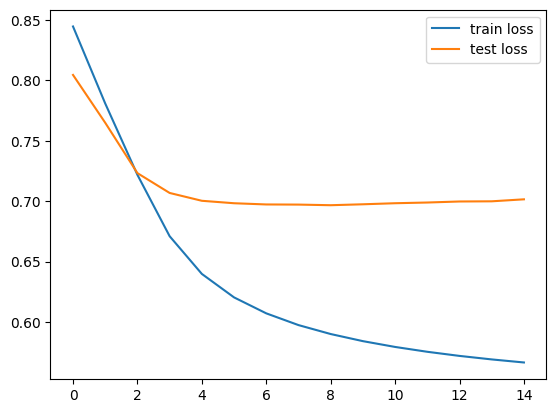

In [16]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

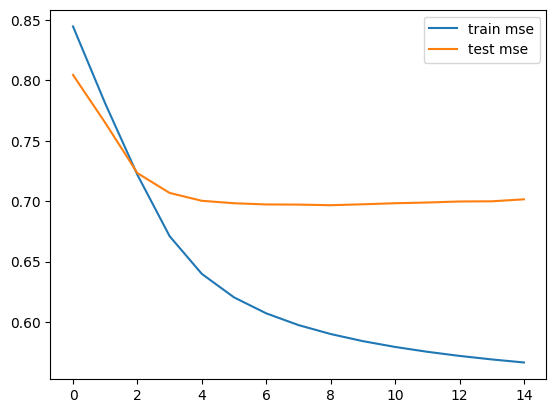

In [17]:
# plot mse
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()

In [18]:
model.save('model_CF.h5')

In [ ]:
model =  tf.keras.models.load_model('model_CF.h5')

2024-06-15 23:46:13.331634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-15 23:46:13.339724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-15 23:46:13.340032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-15 23:46:13.340604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [19]:
# Datos para recomendar
user_id = 1
movie_ids = np.array(df["movieId"].values[:400])  # IDs de películas disponibles

# Crear las entradas para el modelo
user_ids = np.full(len(movie_ids), user_id)

# Hacer predicciones
predicted_ratings = model.predict([user_ids, movie_ids])

# Seleccionar las mejores recomendaciones
top_indices = np.argsort(predicted_ratings[:, 0])[::-1]
top_movie_ids = movie_ids[top_indices]

print(
    "Películas recomendadas para el usuario {}: {}".format(user_id, top_movie_ids[:50])
)

13/13 [==============================] - 0s 1ms/step
Películas recomendadas para el usuario 1: [ 4973  4973  8014  1273 44555  4928   926   926  2010   509  1281   750
   750   750   750   903   314 86320  1284    17    17  2692  2692  3160
  3160  7008   923 27857   912   912   541   541  2284   337  2657  2657
  2657  8914  1484   535   342   608   608   608   608  1921  2117  4979
  4979 26550]
